<a href="https://colab.research.google.com/github/temiyemi/visual-web-agent/blob/main/05.amazon_web_agent_detection_paligemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-tune PaliGemma on Object Detection Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md)

PaliGemma is an open vision-language model (VLM) inspired by PaLI-3, built with
open components, such as
the [SigLIP vision model](https://colab.research.google.com/github/google-research/big_vision/blob/main/big_vision/configs/proj/image_text/SigLIP_demo.ipynb)
and
the [Gemma language model](https://ai.google.dev/gemma).
PaliGemma is designed as a versatile model for transfer to a wide range of
vision-language tasks such as image and short video caption, visual question
answering, text reading, object detection and object segmentation. Together with
the pretrained and transfer checkpoints at multiple resolutions, we provide a
checkpoint transferred to a mixture of tasks that can be used for off-the-shelf
exploration.

This notebook is an extension of the [official notebook](https://colab.research.google.com/github/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/finetune_paligemma.ipynb) prepared by Google Research.

![PaliGemma model](https://storage.cloud.google.com/com-roboflow-marketing/notebooks/examples/paligemma.png)

To make it runnable on a T4 colab runtime with 16GB HBM and 12GB RAM, we opt to only finetune the attention layers of the language model and freeze the other parameters.

 * Download and parse Roboflow Universe dataset.
 * Install deps, download model checkpoint and training data.
 * Load the model onto GPU devices.
 * Prepare the input to the model for training and inference.
 * Finetune the model and inspect output in validation split.

## Download and parse Roboflow Universe dataset

**NOTE:**
PaliGemma requires the dataset to be in the appropriate format (which Roboflow now supports). You will need to add [your ROBOFLOW_API_KEY](https://app.roboflow.com/settings/api) to your Colab secrets (click the Key icon on the left) or enter it in the cell below. You can use Roboflow to easily convert any dataset into this format.

In [1]:
!pip install -q roboflow supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.7 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("fellowshipai-w2w6v").project("amazonwebagent-2")
version = project.version(13)
dataset = version.download("paligemma")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to amazonwebagent-2-13 in paligemma:: 100%|██████████| 82/82 [00:00<00:00, 1315.66it/s]


**NOTE:** Before parsing the dataset, it's worth checking the names of the object classes in the original dataset. If they are of low quality, rename them.

In [3]:
!head -n 5 {dataset.location}/dataset/_annotations.train.jsonl

{"image":"9_png.rf.182ea9d33d795124ca2853a993d55be0.jpg","prefix":"detect button ; clickable ; productlink ; searchbar","suffix":"<loc0040><loc0764><loc0086><loc0880> button ; <loc0240><loc0000><loc0271><loc0069> clickable ; <loc0195><loc0000><loc0225><loc0023> clickable ; <loc0218><loc0000><loc0249><loc0071> clickable ; <loc0164><loc0000><loc0195><loc0069> clickable ; <loc0091><loc0000><loc0121><loc0024> clickable ; <loc0128><loc0000><loc0159><loc0072> clickable ; <loc0810><loc0000><loc0835><loc0101> clickable ; <loc0839><loc0000><loc0863><loc0068> clickable ; <loc0744><loc0000><loc0768><loc0066> clickable ; <loc0712><loc0000><loc0736><loc0063> clickable ; <loc0268><loc0000><loc0292><loc0069> clickable ; <loc0676><loc0000><loc0700><loc0061> clickable ; <loc0391><loc0000><loc0415><loc0069> clickable ; <loc0343><loc0000><loc0367><loc0072> clickable ; <loc0369><loc0000><loc0393><loc0072> clickable ; <loc0316><loc0000><loc0340><loc0066> clickable ; <loc0294><loc0000><loc0318><loc0069> cli

In [4]:
!head -n 5 {dataset.location}/dataset/_annotations.valid.jsonl

{"image":"screenshot4_jpg.rf.2c643bfeb2596da83e36d867f16de29a.jpg","prefix":"detect button ; clickable ; productlink ; searchbar","suffix":"<loc0008><loc0013><loc0059><loc0144> clickable ; <loc0132><loc0015><loc0175><loc0100> clickable ; <loc0196><loc0013><loc0229><loc0111> clickable ; <loc0246><loc0012><loc0287><loc0128> clickable ; <loc0371><loc0022><loc0414><loc0285> clickable ; <loc0426><loc0020><loc0469><loc0283> clickable ; <loc0482><loc0018><loc0525><loc0282> clickable ; <loc0541><loc0020><loc0584><loc0283> clickable ; <loc0597><loc0018><loc0640><loc0282> clickable ; <loc0652><loc0017><loc0695><loc0280> clickable ; <loc0709><loc0018><loc0752><loc0282> clickable ; <loc0767><loc0017><loc0810><loc0280> clickable ; <loc0820><loc0015><loc0864><loc0278> clickable ; <loc0876><loc0015><loc0920><loc0278> clickable ; <loc0012><loc0294><loc0062><loc0328> clickable"}
{"image":"screenshot11_jpg.rf.00d02746217fa32b9c6405f7ea4facd8.jpg","prefix":"detect button ; clickable ; productlink ; searc

**NOTE:** Let's verify if the dataset conversion was successful.

In [5]:
import re
import numpy as np
import supervision as sv
from typing import Tuple, List, Optional


def from_pali_gemma(
    response: str,
    resolution_wh: Tuple[int, int],
    classes: Optional[List[str]] = None
) -> sv.Detections:
    _SEGMENT_DETECT_RE = re.compile(
        r'(.*?)' +
        r'<loc(\d{4})>' * 4 + r'\s*' +
        '(?:%s)?' % (r'<seg(\d{3})>' * 16) +
        r'\s*([^;<>]+)? ?(?:; )?',
    )

    width, height = resolution_wh
    xyxy_list = []
    class_name_list = []

    while response:
        m = _SEGMENT_DETECT_RE.match(response)
        if not m:
            break

        gs = list(m.groups())
        before = gs.pop(0)
        name = gs.pop()
        y1, x1, y2, x2 = [int(x) / 1024 for x in gs[:4]]
        y1, x1, y2, x2 = map(round, (y1*height, x1*width, y2*height, x2*width))

        content = m.group()
        if before:
            response = response[len(before):]
            content = content[len(before):]

        xyxy_list.append([x1, y1, x2, y2])
        class_name_list.append(name.strip())
        response = response[len(content):]

    xyxy = np.array(xyxy_list)
    class_name = np.array(class_name_list)

    if classes is None:
        class_id = None
    else:
        class_id = np.array([classes.index(name) for name in class_name])

    return sv.Detections(
        xyxy=xyxy,
        class_id=class_id,
        data={'class_name': class_name}
    )

{'image': '9_png.rf.182ea9d33d795124ca2853a993d55be0.jpg', 'prefix': 'detect button ; clickable ; productlink ; searchbar', 'suffix': '<loc0040><loc0764><loc0086><loc0880> button ; <loc0240><loc0000><loc0271><loc0069> clickable ; <loc0195><loc0000><loc0225><loc0023> clickable ; <loc0218><loc0000><loc0249><loc0071> clickable ; <loc0164><loc0000><loc0195><loc0069> clickable ; <loc0091><loc0000><loc0121><loc0024> clickable ; <loc0128><loc0000><loc0159><loc0072> clickable ; <loc0810><loc0000><loc0835><loc0101> clickable ; <loc0839><loc0000><loc0863><loc0068> clickable ; <loc0744><loc0000><loc0768><loc0066> clickable ; <loc0712><loc0000><loc0736><loc0063> clickable ; <loc0268><loc0000><loc0292><loc0069> clickable ; <loc0676><loc0000><loc0700><loc0061> clickable ; <loc0391><loc0000><loc0415><loc0069> clickable ; <loc0343><loc0000><loc0367><loc0072> clickable ; <loc0369><loc0000><loc0393><loc0072> clickable ; <loc0316><loc0000><loc0340><loc0066> clickable ; <loc0294><loc0000><loc0318><loc0069

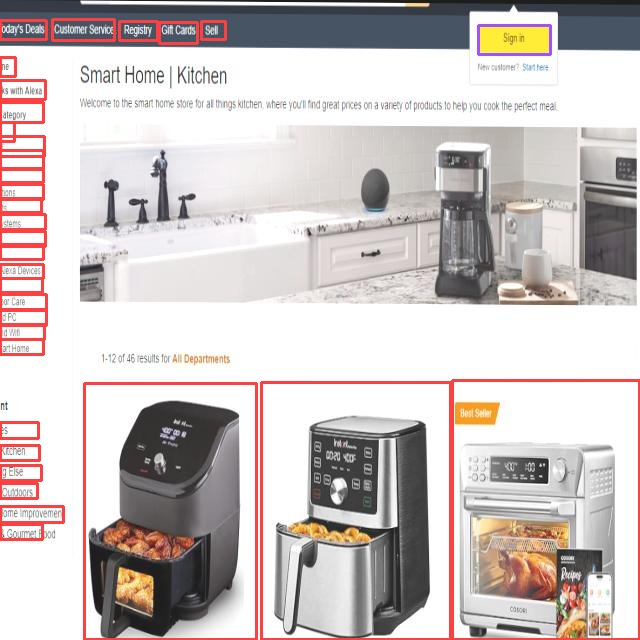

In [6]:
from PIL import Image
import json

first = json.loads(open(f"{dataset.location}/dataset/_annotations.train.jsonl").readline())
print(first)

image = Image.open(f"{dataset.location}/dataset/{first.get('image')}")
CLASSES = first.get('prefix').replace("detect ", "").split(" ; ")
detections = from_pali_gemma(first.get('suffix'), image.size, CLASSES)

sv.BoundingBoxAnnotator().annotate(image, detections)

## Setup

In [7]:
# @title Fetch big_vision code and install dependencies.
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.9 MB/s eta 0:00:00


### Configure your API key to access Kaggle

To use PaliGemma, you must provide your Kaggle username and a Kaggle API key.

1. To generate a Kaggle API key, go to the **Account** tab of your Kaggle user profile and select **Create New Token**. This will trigger the download of a `kaggle.json` file containing your API credentials.
1. In Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.

To be able to download, you will also need to acknowledge the Terms and Conditions of the PaliGemma on:

* https://www.kaggle.com/models/google/paligemma/



In [8]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [10]:
# @title Download checkpoint, tokenizer and dataset to local filesystem.
#
import os
import kagglehub

MODEL_PATH = "./paligemma-3b-pt-224.f16.npz"
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  # Note: kaggle archive contains the same checkpoint in multiple formats.
  # Download only the float16 model.
  MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

100%|██████████| 5.45G/5.45G [01:34<00:00, 61.8MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/./paligemma-3b-pt-224.f16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
- [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


## Training

In [11]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.26
JAX platform: gpu
JAX devices:  1


In [12]:
# @title Construct model and load params into RAM.

# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

In [13]:
# @title Move params to GPU/TPU memory.
#
# To keep HBM usage low and fit in a T4 GPU (16GB HBM) we opt to only finetune
# a part of the parameters. Additionally we keep the frozen params in float16
# and cast trainable to float32.

# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

#
# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default (12GB RAM).
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

In [14]:
# @title Define preprocess functions to create inputs to the model.

def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if its a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


In [15]:
# @title Function to iterate over train and validation examples.
SEQLEN = 128

# TODO: Consider data iterators skipping big_vision and tf.data?
train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(dataset.location, "dataset/_annotations.train.jsonl"),
    fopen_keys={"image": f"{dataset.location}/dataset"})

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(dataset.location, "dataset/_annotations.valid.jsonl"),
    fopen_keys={"image": f"{dataset.location}/dataset"})


def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    # prefix = "caption en"  # Could also be a different prefix per example.
    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    # prefix = "caption en"  # Could also be a different prefix per example.
    prefix = example["prefix"].decode().lower()
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


result render failed, result: <loc0007><loc0702><loc0055><loc0765> clickable ; <loc0002><loc0769><loc0055><loc0873> clickable ; <loc0002><loc0879><loc0050><loc0939> clickable ; <loc0000><loc0946><loc0051><loc1014> clickable ; <loc0085><loc0773><loc0129><loc0881> button ; <loc0701><loc0005><loc0728><loc0101> clickable ; <loc0656><loc0006><loc0676><loc0102> clickable ; <loc0629><loc0007><loc0655><loc0103> clickable ; <loc0607><loc0006><loc0628><loc0120> clickable ; <loc0581><loc0007><loc0607><loc0103> clickable ; <loc0560><loc0006><loc0580><loc0101> clickable ; <loc0533><loc0007><loc0559><loc0102> clickable ; <loc0511><loc0008><loc0532><loc0103> clickable ; <loc0674><loc0006><loc0701><loc0102> clickable ; <loc0449><loc0008><loc0475><loc0104> clickable ; <loc0403><loc0008><loc0423><loc0104> clickable ; <loc0376><loc0008><loc0403><loc0103>
result render failed, result: <loc0000><loc0881><loc0056><loc0951> clickable ; <loc0000><loc0955><loc0056><loc1023> clickable ; <loc0000><loc0768><loc00


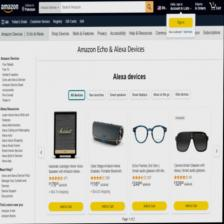
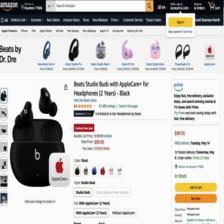
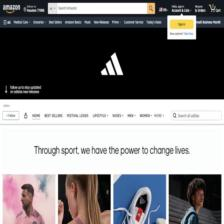
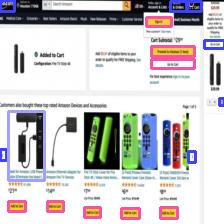
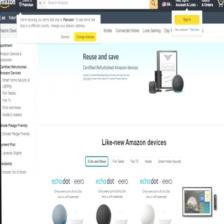
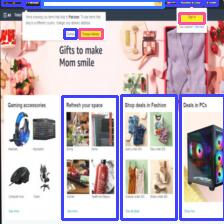
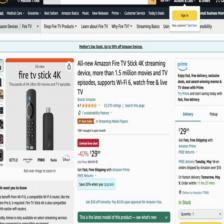
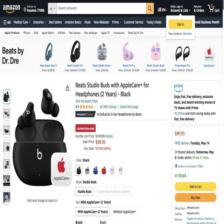

In [16]:
# @title Inspect training examples.
def split_and_keep_second_part(s):
  parts = s.split('\n', 1)
  if len(parts) > 1:
    return parts[1]
  return s

def render_inline(image, resize=(128, 128)):
  """Convert image into inline html."""
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
  h, w, _ = image.shape
  try:
      detections = from_pali_gemma(caption, (w, h), CLASSES)
      image = sv.BoundingBoxAnnotator().annotate(image, detections)
  except:
      print("result render failed, result:", caption)
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """

html_out = ""
for idx, example in zip(range(8), train_data_iterator()):
  caption = postprocess_tokens(example["text"])  # detokenize model input.
  caption = split_and_keep_second_part(caption)
  html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

In [17]:
# @title Define the training step and evaluation loop.
#
# The main update_fn using simple SGD.
#
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

Model predictions



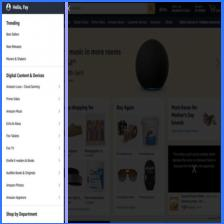
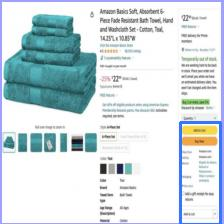
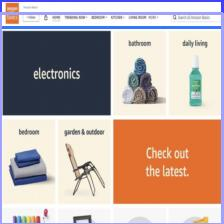
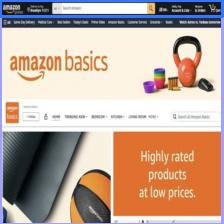
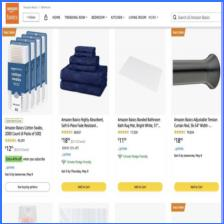
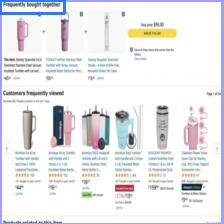
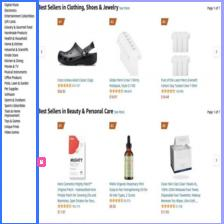
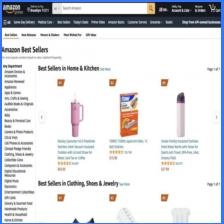

In [18]:
# @title Let't check model performance without finetuning

print("Model predictions")
html_out = ""
for image, caption in make_predictions(validation_data_iterator(), num_examples=8, batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))

**NOTE:** We see that in most cases, the model defaults to returning a box containing the entire skeleton visible in the image. We need to be more precise.

step:  1/64   lr: 0.00167   loss: 4.1430
Model predictions at step 1



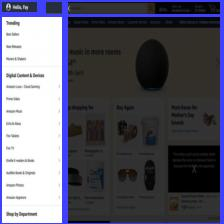
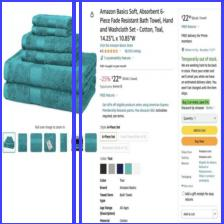
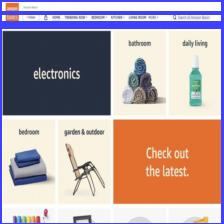
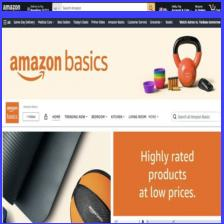

step:  2/64   lr: 0.00333   loss: 3.0121
step:  3/64   lr: 0.00500   loss: 3.0598
step:  4/64   lr: 0.00667   loss: 3.0688
step:  5/64   lr: 0.00833   loss: 3.0838
step:  6/64   lr: 0.01000   loss: 4.3280
step:  7/64   lr: 0.00999   loss: 3.5405
step:  8/64   lr: 0.00997   loss: 3.0956
Model predictions at step 8



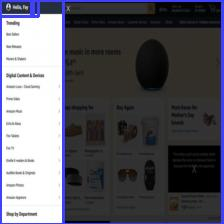
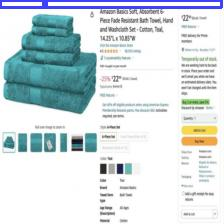
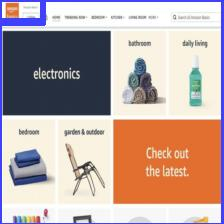
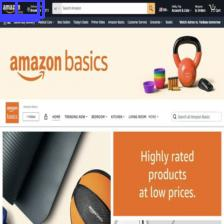

step:  9/64   lr: 0.00994   loss: 3.0414
step: 10/64   lr: 0.00989   loss: 3.0718
step: 11/64   lr: 0.00982   loss: 3.1963
step: 12/64   lr: 0.00975   loss: 3.0873
step: 13/64   lr: 0.00966   loss: 3.0501
step: 14/64   lr: 0.00955   loss: 2.9481
step: 15/64   lr: 0.00944   loss: 2.9358
step: 16/64   lr: 0.00931   loss: 2.7647
Model predictions at step 16



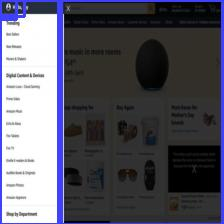
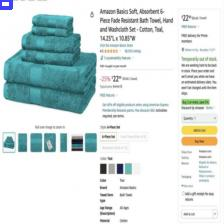
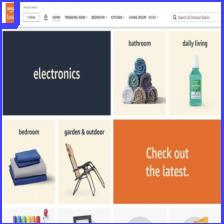
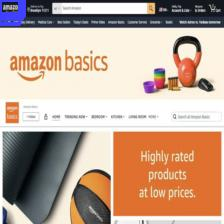

step: 17/64   lr: 0.00917   loss: 2.9262
step: 18/64   lr: 0.00901   loss: 2.8811
step: 19/64   lr: 0.00885   loss: 2.7448
step: 20/64   lr: 0.00867   loss: 2.7216
step: 21/64   lr: 0.00849   loss: 2.8365
step: 22/64   lr: 0.00829   loss: 2.8269
step: 23/64   lr: 0.00809   loss: 2.6997
step: 24/64   lr: 0.00787   loss: 2.6895
Model predictions at step 24



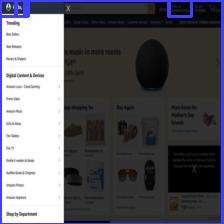
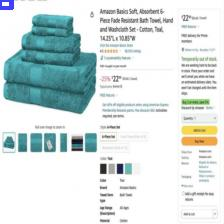
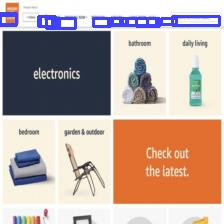
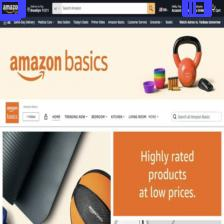

step: 25/64   lr: 0.00765   loss: 2.7389
step: 26/64   lr: 0.00742   loss: 2.7951
step: 27/64   lr: 0.00719   loss: 2.8321
step: 28/64   lr: 0.00694   loss: 2.6986
step: 29/64   lr: 0.00670   loss: 2.6404
step: 30/64   lr: 0.00644   loss: 2.5268
step: 31/64   lr: 0.00619   loss: 2.5530
step: 32/64   lr: 0.00593   loss: 2.5637
Model predictions at step 32



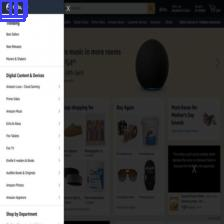
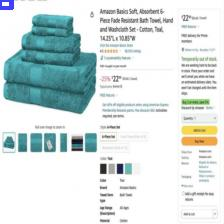
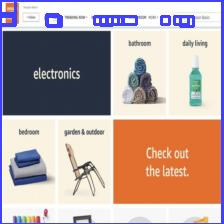
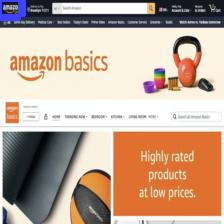

step: 33/64   lr: 0.00566   loss: 2.5778
step: 34/64   lr: 0.00540   loss: 2.6173
step: 35/64   lr: 0.00513   loss: 2.5565
step: 36/64   lr: 0.00487   loss: 2.4659
step: 37/64   lr: 0.00460   loss: 2.4652
step: 38/64   lr: 0.00434   loss: 2.4368
step: 39/64   lr: 0.00407   loss: 2.5933
step: 40/64   lr: 0.00381   loss: 2.5604
Model predictions at step 40



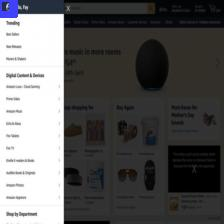
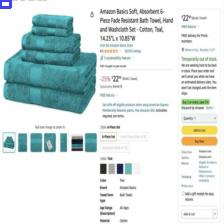
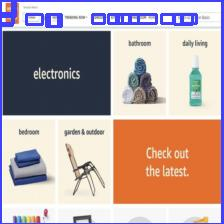
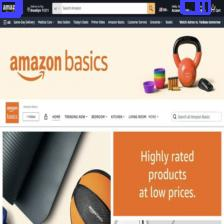

step: 41/64   lr: 0.00356   loss: 2.4888
step: 42/64   lr: 0.00330   loss: 2.4527
step: 43/64   lr: 0.00306   loss: 2.3944
step: 44/64   lr: 0.00281   loss: 2.3663
step: 45/64   lr: 0.00258   loss: 2.4292
step: 46/64   lr: 0.00235   loss: 2.4017
step: 47/64   lr: 0.00213   loss: 2.3783
step: 48/64   lr: 0.00191   loss: 2.3286
Model predictions at step 48



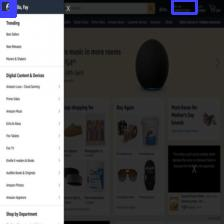
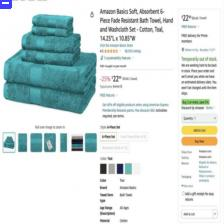
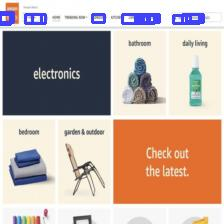
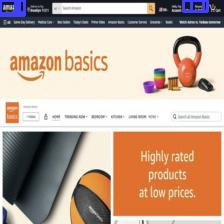

step: 49/64   lr: 0.00171   loss: 2.3054
step: 50/64   lr: 0.00151   loss: 2.3285
step: 51/64   lr: 0.00133   loss: 2.2582
step: 52/64   lr: 0.00115   loss: 2.3979
step: 53/64   lr: 0.00099   loss: 2.2691
step: 54/64   lr: 0.00083   loss: 2.2159
step: 55/64   lr: 0.00069   loss: 2.3539
step: 56/64   lr: 0.00056   loss: 2.3195
Model predictions at step 56



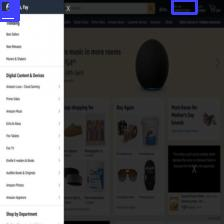
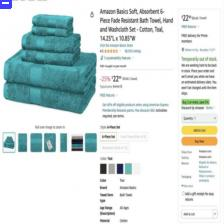
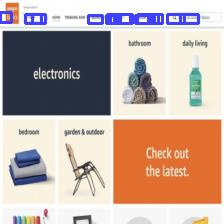
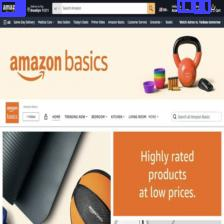

step: 57/64   lr: 0.00045   loss: 2.4691
step: 58/64   lr: 0.00034   loss: 2.2858
step: 59/64   lr: 0.00025   loss: 2.2744
step: 60/64   lr: 0.00018   loss: 2.2851
step: 61/64   lr: 0.00011   loss: 2.2901
step: 62/64   lr: 0.00006   loss: 2.2958
step: 63/64   lr: 0.00003   loss: 2.2806
step: 64/64   lr: 0.00001   loss: 2.3310
Model predictions at step 64



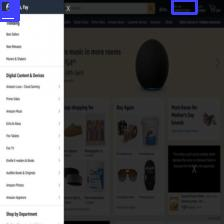
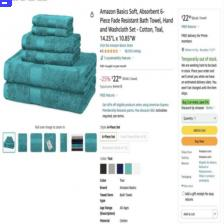
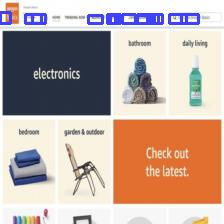
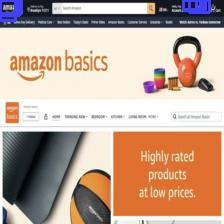

CPU times: user 13min 17s, sys: 937 ms, total: 13min 18s
Wall time: 13min 58s


In [19]:
# @title Run training loop.
#
# Run a short training loop with cosine learning rate schedule.
#
# Note: the first step can be quite slow on some machines (up to several minutes)
# due to XLA compilation of the jax.jit'd function.
#
%%time

BATCH_SIZE = 8
TRAIN_EXAMPLES = 512
# TRAIN_EXAMPLES = 256
LEARNING_RATE = 0.01

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 8

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  if step == 1 or (step % EVAL_STEPS) == 0:
    print(f"Model predictions at step {step}")
    html_out = ""
    for image, caption in make_predictions(
        validation_data_iterator(), num_examples=4, batch_size=4):
      html_out += render_example(image, caption)
    display(HTML(html_out))


Model predictions



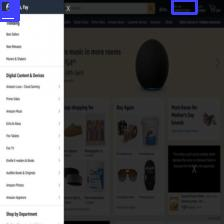
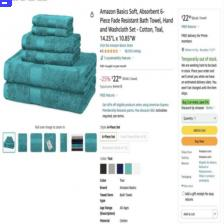
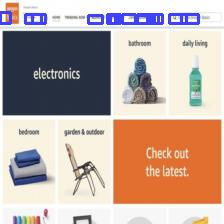
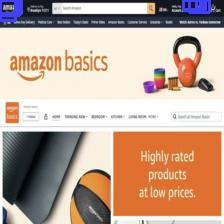
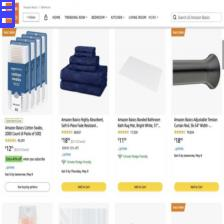
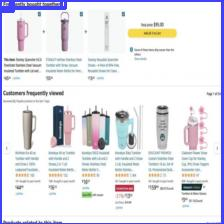
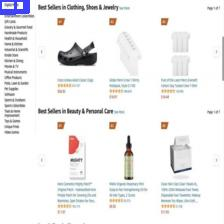
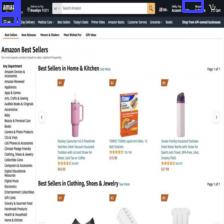

CPU times: user 25.4 s, sys: 98.9 ms, total: 25.5 s
Wall time: 33.2 s


In [20]:
# @title Evaluate the model on all examples.
#
# The validation data consists of 10 images in a different domain than training
# data.
%%time

print("Model predictions")
html_out = ""
for image, caption in make_predictions(validation_data_iterator(), batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))


## Save fine-tuned model locally

In [ ]:
flat, _ = big_vision.utils.tree_flatten_with_names(params)
with open("/content/fine-tuned-paligemma-3b-pt-224.f16.npz", "wb") as f:
  np.savez(f, **{k: v for k, v in flat})

# Congratulations

You now have a fine-tuned PaliGemma model! Next, it will be time to deploy it so we can get predictions. You will soon be able to do this in two lines of code with [Roboflow Inference](https://github.com/roboflow/inference); stay tuned for updates.

⭐️ If you enjoyed this notebook, [**star the Roboflow Notebooks repo**](https://https://github.com/roboflow/notebooks) (and [**supervision**](https://github.com/roboflow/supervision) while you're at it) and let us know what tutorials you'd like to see us do next. ⭐️